# Calculating the effect of the HR-PC$_1$ relation on the H$_0$ measurement

This will be done by looking at the difference in mean/distribution (in PC$_1$ space) between the calibration and Hubble flow samples. We will at this though both local and global age PCA methods.

In [1]:
from glob import glob
import datetime

import numpy as np
from astropy.table import Table
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
import seaborn as sns

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

## Gather Data

### Hubble Flow

In [3]:
HR = pd.read_csv('../data/campbell_local.tsv', sep='\t', usecols=['SNID', 'redshift', 'hr', 'err_mu'], index_col='SNID')
HR.rename(columns={'err_mu': 'hr uncert'}, inplace=True)
HR = HR[HR['redshift']<0.2]  
HR = HR[HR['hr']<0.7]
HR.describe()

,redshift,hr uncert,hr
count,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.023348
std,0.042126,0.016502,0.185996
min,0.045248,0.056201,-0.495474
25%,0.114303,0.065649,-0.152180
50%,0.154056,0.075748,-0.037427
75%,0.180766,0.085845,0.090790
max,0.198704,0.133972,0.497041


In [4]:
t = Table.read('../data/SDSS_Photometric_SNe_Ia.fits')
salt = t['CID','Z','X1','X1_ERR','COLOR','COLOR_ERR'].to_pandas()
salt.columns = salt.columns.str.lower()
salt.rename(columns={'cid': 'SNID', 'z': 'Campbell redshift'}, inplace=True)
salt.set_index('SNID', inplace=True)
salt.describe()

,Campbell redshift,x1,x1_err,color,color_err
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,0.294032,-0.006514,0.765859,-0.013105,0.059070
std,0.103553,1.082517,0.506811,0.100019,0.023878
min,0.037069,-2.952440,0.061210,-0.245912,0.024959
25%,0.220188,-0.776738,0.426394,-0.084207,0.041157
50%,0.294489,0.022410,0.702974,-0.019256,0.055565
75%,0.369411,0.793196,1.011968,0.051200,0.073263
max,0.700345,2.887440,8.048070,0.246569,0.195758


In [5]:
galaxy = pd.read_csv('../resources/kcorrect_stellarmass.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy.describe()

,gal redshift,stellar mass
count,305.000000,3.050000e+02
mean,0.223845,4.177042e+10
std,0.071923,5.006189e+10
min,0.045363,3.521470e+07
25%,0.175242,8.513790e+09
50%,0.236310,2.342800e+10
75%,0.284038,5.800110e+10
max,0.336325,3.486340e+11


In [6]:
# local Hubble flow age
age = pd.read_csv('../resources/ages_campbell.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age.rename(columns={'# sn id': 'SNID'}, inplace=True)
age.set_index('SNID', inplace=True)
age.describe()

,age
count,103.000000
mean,5.221552
std,2.121162
min,1.628953
25%,3.447774
50%,5.071533
75%,6.625620
max,9.740748


In [7]:
# global Hubble flow age
age_global = pd.read_csv('../resources/ages_campbellG.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age_global.rename(columns={'# sn id': 'SNID'}, inplace=True)
age_global.set_index('SNID', inplace=True)
age_global.describe()

,age
count,103.000000
mean,5.489302
std,2.256922
min,1.206989
25%,4.082504
50%,5.312133
75%,7.369338
max,10.738602


In [8]:
data = pd.concat([HR, salt, galaxy, age], axis=1)
data.dropna(inplace=True)
data.describe()

,redshift,hr uncert,hr,Campbell redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.030000e+02,103.000000
mean,0.143292,0.078358,-0.023348,0.143292,-0.177168,0.268273,0.010006,0.032914,0.143292,3.082438e+10,5.221552
std,0.042126,0.016502,0.185996,0.042126,1.020424,0.127680,0.083329,0.006243,0.042150,3.486086e+10,2.121162
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,3.521470e+07,1.628953
25%,0.114303,0.065649,-0.152180,0.114303,-0.769090,0.176328,-0.041371,0.028793,0.114276,5.819550e+09,3.447774
50%,0.154056,0.075748,-0.037427,0.154056,-0.115550,0.236314,-0.004241,0.030807,0.154034,2.032040e+10,5.071533
75%,0.180766,0.085845,0.090790,0.180766,0.693757,0.354695,0.081210,0.035345,0.180752,4.306880e+10,6.625620
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,2.267200e+11,9.740748


In [9]:
data['stellar mass'] = np.log10(data['stellar mass'])
data.describe()

,redshift,hr uncert,hr,Campbell redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.023348,0.143292,-0.177168,0.268273,0.010006,0.032914,0.143292,10.152806,5.221552
std,0.042126,0.016502,0.185996,0.042126,1.020424,0.127680,0.083329,0.006243,0.042150,0.693578,2.121162
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.628953
25%,0.114303,0.065649,-0.152180,0.114303,-0.769090,0.176328,-0.041371,0.028793,0.114276,9.764876,3.447774
50%,0.154056,0.075748,-0.037427,0.154056,-0.115550,0.236314,-0.004241,0.030807,0.154034,10.307932,5.071533
75%,0.180766,0.085845,0.090790,0.180766,0.693757,0.354695,0.081210,0.035345,0.180752,10.632817,6.625620
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,9.740748


In [10]:
data_global = pd.concat([HR, salt, galaxy, age_global], axis=1)
data_global.dropna(inplace=True)
data_global['stellar mass'] = np.log10(data_global['stellar mass'])
data_global.describe()

,redshift,hr uncert,hr,Campbell redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.023348,0.143292,-0.177168,0.268273,0.010006,0.032914,0.143292,10.152806,5.489302
std,0.042126,0.016502,0.185996,0.042126,1.020424,0.127680,0.083329,0.006243,0.042150,0.693578,2.256922
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.206989
25%,0.114303,0.065649,-0.152180,0.114303,-0.769090,0.176328,-0.041371,0.028793,0.114276,9.764876,4.082504
50%,0.154056,0.075748,-0.037427,0.154056,-0.115550,0.236314,-0.004241,0.030807,0.154034,10.307932,5.312133
75%,0.180766,0.085845,0.090790,0.180766,0.693757,0.354695,0.081210,0.035345,0.180752,10.632817,7.369338
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,10.738602


Now we have `data` and `data_global` as two data frames for our Hubble flow samples.


### Clibration Sample

Note that I use the host's name as the number, rather than the SN number. A legacy convention from back when I did the Messier object tests

In [11]:
salt_cal = pd.read_csv('../data/calibaration_sample_salt2.4_params.csv',  usecols=['SN','Host', 'x_1', 'c'],
                       comment='#')
salt_cal.rename(columns={'Host': 'SNID'}, inplace=True)
salt_cal.set_index('SNID', inplace=True)
salt_cal

,SN,x_1,c
SNID,,,
4536,1981B,-0.320,0.0300
4639,1990N,0.628,0.0141
3370,1994ae,0.324,-0.0650
3021,1995al,0.711,0.0513
3982,1998aq,-0.397,-0.0857
1309,2002fk,0.220,-0.1010
9391,2003du,0.307,-0.1006
5584,2007af,-0.451,0.0533
1015,2009ig,1.760,-0.0580


In [12]:
galaxy_cal = pd.read_csv('../resources/kcorrect_stellarmass_Riess.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy_cal.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy_cal.describe()

,gal redshift,stellar mass
count,14.000000,1.400000e+01
mean,0.004545,9.450872e+09
std,0.002166,5.597573e+09
min,0.000804,9.531210e+08
25%,0.003577,6.387692e+09
50%,0.004088,9.738740e+09
75%,0.005904,1.443070e+10
max,0.008797,1.846090e+10


In [13]:
redshift_cal = pd.read_csv('../data/riess_local.tsv', sep='\t',
                           usecols=['SNID', 'redshift'], index_col='SNID')
redshift_cal

,redshift
SNID,
101,0.000804
1015,0.008797
1309,0.007138
3021,0.005350
3370,0.004276
3447,0.003556
3972,0.002799
3982,0.003710
4424,0.001620


In [14]:
#Local ages
age_cal = pd.read_csv('../resources/ages_riess.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age_cal.rename(columns={'# sn id': 'SNID'}, inplace=True)
age_cal.set_index('SNID', inplace=True)
age_cal.describe()
age_cal

,age
SNID,
3972,4.486413
3021,6.413803
3982,5.244359
1309,6.633710
3370,5.356959
7250,4.618576
4424,3.537509
101,3.101574
1015,9.648299


In [15]:
#Global ages
age_global_cal = pd.read_csv('../resources/ages_riessG.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age_global_cal.rename(columns={'# sn id': 'SNID'}, inplace=True)
age_global_cal.set_index('SNID', inplace=True)
age_global_cal.describe()
age_global_cal

,age
SNID,
9391,4.382869
4424,2.832870
7250,4.151843
3982,6.062874
5584,6.202993
4639,4.795209
101,4.933728
1309,5.232909
4536,2.963088


In [16]:
calibration = pd.concat([salt_cal, galaxy_cal, age_cal, redshift_cal], axis=1)
calibration.dropna(inplace=True)
calibration['stellar mass'] = np.log10(calibration['stellar mass'])
# calibration.describe()
calibration

,SN,x_1,c,gal redshift,stellar mass,age,redshift
SNID,,,,,,,
101,2011fe,-0.206,-0.0660,0.000804,9.932270,3.101574,0.000804
1015,2009ig,1.760,-0.0580,0.008797,10.266253,9.648299,0.008797
1309,2002fk,0.220,-0.1010,0.007138,10.148390,6.633710,0.007138
3021,1995al,0.711,0.0513,0.005350,10.186730,6.413803,0.005350
3370,1994ae,0.324,-0.0650,0.004276,9.983647,5.356959,0.004276
3447,2012ht,-1.250,-0.0800,0.003556,9.188490,4.022650,0.003556
3972,2011by,0.020,0.0120,0.002799,9.795767,4.486413,0.002799
3982,1998aq,-0.397,-0.0857,0.003710,10.011714,5.244359,0.003710
4424,2012cg,0.450,0.0800,0.001620,9.993304,3.537509,0.001620


In [17]:
calibration_global = pd.concat([salt_cal, galaxy_cal, age_global_cal, redshift_cal], axis=1)
calibration_global.dropna(inplace=True)
calibration_global['stellar mass'] = np.log10(calibration_global['stellar mass'])
# calibration.describe()
calibration_global

,SN,x_1,c,gal redshift,stellar mass,age,redshift
SNID,,,,,,,
101,2011fe,-0.206,-0.0660,0.000804,9.932270,4.933728,0.000804
1015,2009ig,1.760,-0.0580,0.008797,10.266253,9.685944,0.008797
1309,2002fk,0.220,-0.1010,0.007138,10.148390,5.232909,0.007138
3021,1995al,0.711,0.0513,0.005350,10.186730,6.019977,0.005350
3370,1994ae,0.324,-0.0650,0.004276,9.983647,5.044636,0.004276
3447,2012ht,-1.250,-0.0800,0.003556,9.188490,4.438099,0.003556
3972,2011by,0.020,0.0120,0.002799,9.795767,4.135427,0.002799
3982,1998aq,-0.397,-0.0857,0.003710,10.011714,6.062874,0.003710
4424,2012cg,0.450,0.0800,0.001620,9.993304,2.832870,0.001620


Now we have `calibration` and `calibration_global` as our two calibration data sets.

Since age is so important, let's check out the basics stats real quick.

In [18]:
print("LOCAL AGE:")
print(calibration['age'].describe(), '\n')
print(data['age'].describe(), '\n')

print("\n GLOBAL AGE:")
print(calibration_global['age'].describe(), '\n')
print(data_global['age'].describe(), '\n')

LOCAL AGE:
count    14.000000
mean      5.489343
std       1.672208
min       3.101574
25%       4.508886
50%       5.300659
75%       6.460297
max       9.648299
Name: age, dtype: float64 

count    103.000000
mean       5.221552
std        2.121162
min        1.628953
25%        3.447774
50%        5.071533
75%        6.625620
max        9.740748
Name: age, dtype: float64 


 GLOBAL AGE:
count    14.000000
mean      5.063033
std       1.678625
min       2.832870
25%       4.209599
50%       4.864468
75%       5.823210
max       9.685944
Name: age, dtype: float64 

count    103.000000
mean       5.489302
std        2.256922
min        1.206989
25%        4.082504
50%        5.312133
75%        7.369338
max       10.738602
Name: age, dtype: float64 



## Make 4 corner plot.

Show that adifferance in PC$_1$ it is not just a mass step (becuase Riess already accounted for that).

/usr/local/lib/python3.7/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


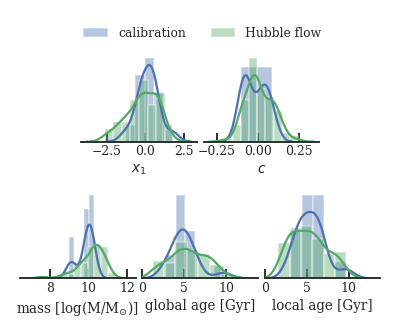

In [72]:
### First 5 parameters with both global and local ages

# font size is not working
sns.set(context='talk', style='ticks', font='serif', color_codes=True, font_scale=0.75)

# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
# f.tight_layout()   # improve spacing
#https://stackoverflow.com/questions/26767281/position-5-subplots-in-matplotlib
ax1 = plt.subplot2grid(shape=(2,18), loc=(0,3), colspan=6)
ax2 = plt.subplot2grid((2,18), (0,9), colspan=6)
ax3 = plt.subplot2grid((2,18), (1,0), colspan=6)
ax4 = plt.subplot2grid((2,18), (1,6), colspan=6)
ax5 = plt.subplot2grid((2,18), (1,12), colspan=6)
f = plt.gcf()
f.tight_layout()   # improve spacing

#x_1
sns.distplot(calibration['x_1'], label='calibration', ax=ax1)
sns.distplot(data['x1'], label='Hubble\nflow', ax=ax1, color='g')

#c
sns.distplot(calibration['c'], label='calibration', ax=ax2)
sns.distplot(data['color'], label='Hubble flow', ax=ax2, color='g')


#mass
sns.distplot(calibration['stellar mass'], label='calibration', ax=ax3)
sns.distplot(data['stellar mass'], label='Hubble flow', ax=ax3, color='g')

#global age
sns.distplot(calibration_global['age'], label='calibration', ax=ax4)
sns.distplot(data_global['age'], label='Hubble flow', ax=ax4, color='g')
ax4.set_xlim([0,13.8])

#local age
sns.distplot(calibration['age'], label='calibration', ax=ax5)
sns.distplot(data['age'], label='Hubble flow', ax=ax5, color='g')
ax5.set_xlim([0,13.8])


# Change tick locations
# ax1.tick_params(axis='both', top='on', right='on', direction='in')
# ax2.tick_params(axis='both', top='on', right='on', direction='in')
# ax3.tick_params(axis='both', top='on', right='on', direction='in')
# ax4.tick_params(axis='both', top='on', right='on', direction='in')
# ax5.tick_params(axis='both', top='on', right='on', direction='in')
ax1.tick_params(axis='both', direction='in')
ax2.tick_params(axis='both', direction='in')
ax3.tick_params(axis='both', direction='in')
ax4.tick_params(axis='both', direction='in')
ax5.tick_params(axis='both', direction='in')

# remove y values
ax1.get_yaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])
ax5.get_yaxis().set_ticks([])

#despine
sns.despine(left=True)

# add better labels
ax1.set_xlabel(r'$x_1$')
ax2.set_xlabel(r'$c$')
ax3.set_xlabel(r'mass [log(M/M$_{\odot}$)]')
ax4.set_xlabel(r'global age [Gyr]')
ax5.set_xlabel(r'local age [Gyr]')


# plt.legend()
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# ax1.legend(bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.) # in middle
# ax2.legend(bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.) # better top right
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # ok on top right
# ax1.legend(bbox_to_anchor=(0.1,1.02,1.,0.102), loc=3,
#            ncol=2, mode='expand', borderaxespad=0)   #on top?


#Set up legend
legend_ax = f.add_axes([0.1, 0.95, 0.8, 0.1]) # set up a figure to put the legend on
# remove all the junk
sns.despine(left=True, bottom=True, ax=legend_ax)
legend_ax.get_xaxis().set_ticks([])
legend_ax.get_yaxis().set_ticks([])
# get the legend details
handles, labels = ax2.get_legend_handles_labels()
#plot legend
legend_ax.legend(handles, labels, ncol=2, loc=[0.18,0], frameon=False)


plt.savefig('H0_components_5components.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


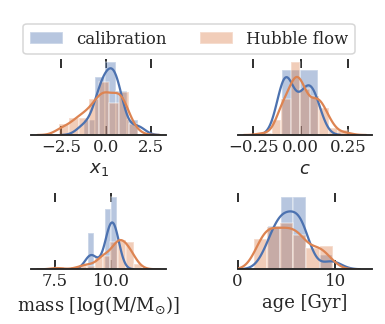

In [19]:
### WITH LOCAL AGES


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.tight_layout()   # improve spacing

#x_1
sns.distplot(calibration['x_1'], label='calibration', ax=ax1)
sns.distplot(data['x1'], label='Hubble\nflow', ax=ax1)

#c
sns.distplot(calibration['c'], label='calibration', ax=ax2)
sns.distplot(data['color'], label='Hubble flow', ax=ax2)


#mass
sns.distplot(calibration['stellar mass'], label='calibration', ax=ax3)
sns.distplot(data['stellar mass'], label='Hubble flow', ax=ax3)

#age
sns.distplot(calibration['age'], label='calibration', ax=ax4)
sns.distplot(data['age'], label='Hubble flow', ax=ax4)
ax4.set_xlim([0,13.8])

# Change tick locations
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax4.tick_params(axis='both', top='on', right='on', direction='in')

# remove y values
ax1.get_yaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

#despine
sns.despine(left=True)

# add better labels
ax1.set_xlabel(r'$x_1$')
ax2.set_xlabel(r'$c$')
ax3.set_xlabel(r'mass [log(M/M$_{\odot}$)]')
ax4.set_xlabel(r'age [Gyr]')


# plt.legend()
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# ax1.legend(bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.) # in middle
# ax2.legend(bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.) # better top right
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # ok on top right
# ax1.legend(bbox_to_anchor=(0.1,1.02,1.,0.102), loc=3,
#            ncol=2, mode='expand', borderaxespad=0)   #on top?


#Set up legend
legend_ax = f.add_axes([0.1, 0.95, 0.8, 0.1]) # set up a figure to put the legend on
# remove all the junk
sns.despine(left=True, bottom=True, ax=legend_ax)
legend_ax.get_xaxis().set_ticks([])
legend_ax.get_yaxis().set_ticks([])
# get the legend details
handles, labels = ax2.get_legend_handles_labels()
#plot legend
legend_ax.legend(handles, labels, ncol=2, loc="upper center")


# plt.savefig('H0_components.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


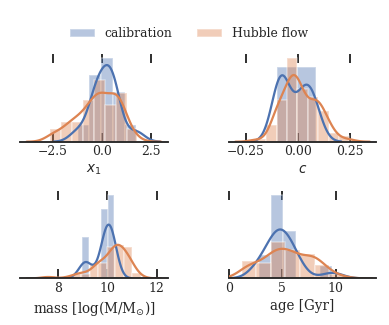

In [71]:
### GLOBAL AGES

# TODO: data should be data_global


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.tight_layout()   # improve spacing

#x_1
sns.distplot(calibration_global['x_1'], label='calibration', ax=ax1)
sns.distplot(data_global['x1'], label='Hubble\nflow', ax=ax1)

#c
sns.distplot(calibration_global['c'], label='calibration', ax=ax2)
sns.distplot(data_global['color'], label='Hubble flow', ax=ax2)


#mass
sns.distplot(calibration_global['stellar mass'], label='calibration', ax=ax3)
sns.distplot(data_global['stellar mass'], label='Hubble flow', ax=ax3)

#age
sns.distplot(calibration_global['age'], label='calibration', ax=ax4)
sns.distplot(data_global['age'], label='Hubble flow', ax=ax4)
ax4.set_xlim([0,13.8])

# Change tick locations
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax4.tick_params(axis='both', top='on', right='on', direction='in')

# remove y values
ax1.get_yaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

#despine
sns.despine(left=True)

# add better labels
ax1.set_xlabel(r'$x_1$')
ax2.set_xlabel(r'$c$')
ax3.set_xlabel(r'mass [log(M/M$_{\odot}$)]')
ax4.set_xlabel(r'age [Gyr]')


# plt.legend()
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# ax1.legend(bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.) # in middle
# ax2.legend(bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.) # better top right
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # ok on top right
# ax1.legend(bbox_to_anchor=(0.1,1.02,1.,0.102), loc=3,
#            ncol=2, mode='expand', borderaxespad=0)   #on top?


#Set up legend
legend_ax = f.add_axes([0.1, 0.95, 0.8, 0.1]) # set up a figure to put the legend on
# remove all the junk
sns.despine(left=True, bottom=True, ax=legend_ax)
legend_ax.get_xaxis().set_ticks([])
legend_ax.get_yaxis().set_ticks([])
# get the legend details
handles, labels = ax2.get_legend_handles_labels()
#plot legend
legend_ax.legend(handles, labels, ncol=2, loc="upper center")


# plt.savefig('H0_components_global.pdf', bbox_inches='tight')
plt.show()

## Make PC$_1$ distibution plot


See if, when combined there is a sytematic shift.

### standarize calibration data sets like the Hubble flow data sets

First with local age.

In [52]:
features = ['x1', 'color', 'stellar mass', 'age']
# z and data are the Hubble flow sample
z = data[data['hr']<0.5].loc[:, features].values
print(z.shape)
print(np.mean(z, axis=0))

(103, 4)
[-1.77167739e-01  1.00061104e-02  1.01528061e+01  5.22155160e+00]


In [53]:
scaler = StandardScaler()
scaler.fit(z)   # get the needed transformation off of z
z = scaler.transform(z)   #this returns the scaled form of z
print(np.mean(z, axis=0))

[ 1.07788643e-17 -2.26356151e-17 -8.66620691e-16 -1.27190599e-16]


Now with global age.

In [54]:
# Get data to fit and transform
z_global = data_global[data_global['hr']<0.5].loc[:, features].values
print(z.shape)
print(np.mean(z_global, axis=0))

# Fit data in scaler
scaler_global = StandardScaler()
scaler_global.fit(z_global)   # get the needed transformation off of z

# transform data
z_global = scaler_global.transform(z_global)   #this returns the scaled form of z
print(np.mean(z_global, axis=0))

(103, 4)
[-1.77167739e-01  1.00061104e-02  1.01528061e+01  5.48930218e+00]
[ 1.07788643e-17 -2.26356151e-17 -8.66620691e-16 -3.19054384e-16]


In [55]:
# [  1.07788643e-17  -2.26356151e-17  -8.66620691e-16   1.26845512e-01]
np.mean((z_global - np.mean(z_global, axis=0))/np.std(z_global)**2, axis=0)

array([ 1.07788643e-17, -1.83240693e-17,  2.15577286e-17, -4.31154573e-17])

In [56]:
print(scaler.mean_)
print(scaler.var_)
print()
print(scaler_global.mean_)
print(scaler_global.var_)

[-1.77167739e-01  1.00061104e-02  1.01528061e+01  5.22155160e+00]
[1.0311568  0.00687628 0.47638034 4.45564521]

[-1.77167739e-01  1.00061104e-02  1.01528061e+01  5.48930218e+00]
[1.0311568  0.00687628 0.47638034 5.04424391]


In [57]:
# scale the LOCAL AGE calibration sample
features = ['x_1', 'c', 'stellar mass', 'age']  # Reset to calibration sample header info
cal_scaled = scaler.transform(calibration.loc[:, features].values)   #get the same scale on new dataset
cal_scaled

array([[-0.02839333, -0.91658279, -0.31952375, -1.00432884],
       [ 1.90767713, -0.82010815,  0.1643673 ,  2.09714991],
       [ 0.39112143, -1.33865936, -0.00639852,  0.66900324],
       [ 0.87464666,  0.49797666,  0.04915122,  0.56482303],
       [ 0.49353818, -0.90452346, -0.2450852 ,  0.06414835],
       [-1.05649992, -1.08541342, -1.39714858, -0.56797367],
       [ 0.19416614,  0.02404497, -0.517296  , -0.34826807],
       [-0.21648563, -1.1541516 , -0.20442077,  0.01080482],
       [ 0.61762001,  0.84407944, -0.23109382, -0.79780699],
       [-0.14065784,  0.24111292,  0.01461856,  0.60796895],
       [ 0.79291021,  0.04936957,  0.01456667,  0.59419186],
       [-0.26966356,  0.52209532, -0.46353862,  0.47773485],
       [ 0.85889023,  0.95261341, -1.43742104, -0.28565684],
       [ 0.47679698, -1.33383563, -1.70045308, -0.30568258]])

In [58]:
# scale the GLOBAL AGE calibration sample
features = ['x_1', 'c', 'stellar mass', 'age']  # Reset to calibration sample header info
cal_scaled_global = scaler_global.transform(calibration_global.loc[:, features].values)   #get the same scale on new dataset
cal_scaled_global

array([[-0.02839333, -0.91658279, -0.31952375, -0.24736837],
       [ 1.90767713, -0.82010815,  0.1643673 ,  1.86854624],
       [ 0.39112143, -1.33865936, -0.00639852, -0.11415848],
       [ 0.87464666,  0.49797666,  0.04915122,  0.23628211],
       [ 0.49353818, -0.90452346, -0.2450852 , -0.19798675],
       [-1.05649992, -1.08541342, -1.39714858, -0.46804604],
       [ 0.19416614,  0.02404497, -0.517296  , -0.60280998],
       [-0.21648563, -1.1541516 , -0.20442077,  0.25538181],
       [ 0.61762001,  0.84407944, -0.23109382, -1.18277128],
       [-0.14065784,  0.24111292,  0.01461856, -1.12479175],
       [ 0.79291021,  0.04936957,  0.01456667, -0.30904365],
       [-0.26966356,  0.52209532, -0.46353862,  0.3177695 ],
       [ 0.85889023,  0.95261341, -1.43742104, -0.59550119],
       [ 0.47679698, -1.33383563, -1.70045308, -0.49263705]])

In [59]:
def to_pc1_local(data):
    """need input to be a Nx4 numpy array
    """
    x, c, m, a = data[:,0], data[:,1], data[:,2], data[:,3]
    return -0.256*x+0.001*c+0.153*m+0.954*a

def to_pc1_global(data):
    """need input to be a Nx4 numpy array
    """
    x, c, m, a = data[:,0], data[:,1], data[:,2], data[:,3]
    return -0.199*x+0.003*c+0.2*m+0.959*a

In [60]:
pc1_hubble = to_pc1_local(z)
pc1_hubble_global = to_pc1_global(z_global)
pc1_cal = to_pc1_local(cal_scaled)
pc1_cal_global = to_pc1_global(cal_scaled_global)

In [78]:
# data needed for table in paper
print(calibration.index)
print(pc1_cal)
print(pc1_cal_global)

Int64Index([ 101, 1015, 1309, 3021, 3370, 3447, 3972, 3982, 4424, 4536, 4639,
            5584, 7250, 9391],
           dtype='int64', name='SNID')
[-1.00066474  1.53664376  0.53578437  0.32294974 -0.1035508  -0.48623205
 -0.46107652  0.03329759 -0.95373187  0.61848854  0.36615209  0.4543936
 -0.71136533 -0.67518436]
[-0.2982305   1.44272123 -0.19260683  0.06386404 -0.339814   -0.52129862
 -0.7201209   0.24364519 -1.30087056 -1.04703733 -0.45110055  0.26726256
 -1.02663116 -0.91141365]


### Basic  & Statistical Differances

In [61]:
print('mean: ', np.mean(pc1_hubble), np.mean(pc1_cal), np.mean(pc1_hubble_global), np.mean(pc1_cal_global))
print('median: ', np.median(pc1_hubble), np.median(pc1_cal), np.median(pc1_hubble_global), np.median(pc1_cal_global))
print('std: ', np.std(pc1_hubble), np.std(pc1_cal), np.std(pc1_hubble_global), np.std(pc1_cal_global))

mean:  -2.6516006219202766e-16 -0.03743542619818676 -4.699584842102604e-16 -0.34225936357314307
median:  -0.019271029540444184 -0.03512660446827339 -0.046986305863880494 -0.39545727579936285
std:  1.1725071324174645 0.6964080430607175 1.1890554623655356 0.6805912890111799


In [62]:
## Differneces in mean
print('Local Age:')
delta_mean = abs(np.mean(pc1_hubble) - np.mean(pc1_cal))
uncert = abs(np.std(pc1_cal))/np.sqrt(pc1_cal.size)  #only account for uncertainty in Calibration. Hubble flow is scalled.
print(f'{delta_mean:.5f} +- {uncert:.5f}')
print(f'{delta_mean/uncert:.4f} sigma')

print()

print('Global Age:')
delta_mean = abs(np.mean(pc1_hubble_global) - np.mean(pc1_cal_global))
uncert = abs(np.std(pc1_cal_global))/np.sqrt(pc1_cal_global.size)  #only account for uncertainty in Calibration. Hubble flow is scalled.
print(f'{delta_mean:.5f} +- {uncert:.5f}')
print(f'{delta_mean/uncert:.4f} sigma')

Local Age:
0.03744 +- 0.18612
0.2011 sigma

Global Age:
0.34226 +- 0.18190
1.8816 sigma


In [63]:
### LOCAL AGES
print(ks_2samp(pc1_cal,pc1_hubble))
print(mannwhitneyu(pc1_cal,pc1_hubble, alternative='less'))

Ks_2sampResult(statistic=0.24271844660194175, pvalue=0.40832952432058295)
MannwhitneyuResult(statistic=741.0, pvalue=0.568342351259351)


In [64]:
### GLOBAL AGES
print(ks_2samp(pc1_cal_global,pc1_hubble_global))
print(mannwhitneyu(pc1_cal_global,pc1_hubble_global, alternative='less'))

Ks_2sampResult(statistic=0.3072122052704578, pvalue=0.15903083171591087)
MannwhitneyuResult(statistic=573.0, pvalue=0.10773207536607932)


Mean PC$_1$ is zero (by definition) for the two Hubble flows. The mean using local is -0.037 and using global is -0.340. The medians are not that much different, so it is not the result of a single outlier. The results of local PCA are very similar distirubtion (KS-test p-value 0.408) but there is a slight difference between the two data sets using the global analsysis (KS-test p-value 0.067 or 1.5 $\sigma$, MWU p-value 0.0577 two tail or 1.9 $\sigma$). So basically, no clear effect but maybe.

## Make PC$_1$ Comparison Figures

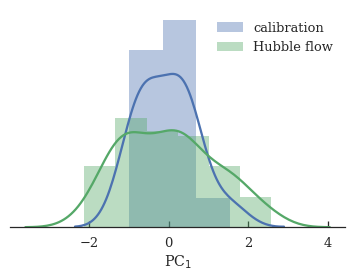

In [62]:
### LOCAL AGE PC_1


fig, ax = plt.subplots(1,1)

sns.distplot(pc1_cal, label='calibration')
sns.distplot(pc1_hubble, label='Hubble flow')

plt.xlabel(r'PC$_1$')

ax.tick_params(axis='both', top='on', right='on', direction='in')
ax.get_yaxis().set_ticks([])
sns.despine(left=True)

plt.legend()

# plt.savefig('H0_pc1.pdf', bbox_inches='tight')
plt.show()

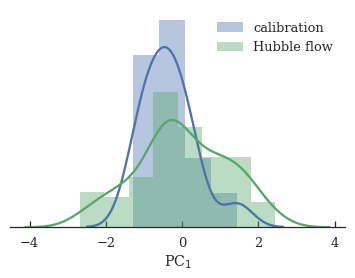

In [74]:
### GLOBAL AGE PC_1

# TODO: This is the PCA-local distribution


fig, ax = plt.subplots(1,1)

sns.distplot(pc1_cal_global, label='calibration')
sns.distplot(pc1_hubble_global, label='Hubble flow')

plt.xlabel(r'PC$_1$')

ax.tick_params(axis='both', top='on', right='on', direction='in')
ax.get_yaxis().set_ticks([])
sns.despine(left=True)

plt.legend()

# plt.savefig('H0_pc1_global.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


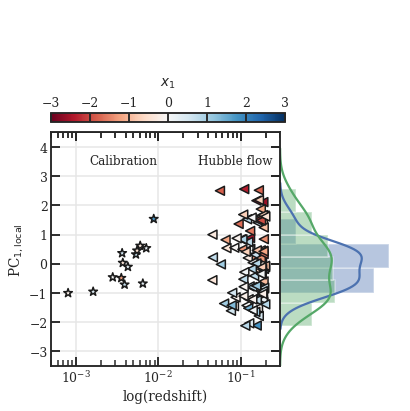

In [69]:
## Local

# combine data into a list
redshift = redshift_cal['redshift'].tolist()+data['redshift'].tolist()   # was two DataFrames
pc1 = np.append(pc1_cal, pc1_hubble).tolist()     # was two numpy arrays
df = pd.DataFrame({'redshift': redshift, 'pc1': pc1})
# documentation says [0,100] but it looks like it should be [0,1]
# cmap = sns.diverging_palette(240, 20, s=99, l=45, sep=20, n=15, center='light', as_cmap=True)
# was 220, 20



# Set up JointGrid
g = sns.JointGrid(x='redshift', y='pc1', data=df, space=0, ratio=2)

# Add data to joint plot
normalize = matplotlib.colors.Normalize(vmin=-3.0, vmax=3.0)
s = g.ax_joint.scatter(redshift_cal['redshift'], pc1_cal, marker='*',
                       c=calibration['x_1'], norm=normalize, vmin=-3.0, vmax=3.0,
                       cmap='RdBu', edgecolor='k',
                       label='calibration')
s = g.ax_joint.scatter(data['redshift'], pc1_hubble, marker='<', 
                       c=data['x1'], norm=normalize, vmin=-3.0, vmax=3.0,
                       cmap="RdBu", edgecolor='k',
                       label='Hubble flow')
# cbaxes = plt.gcf().add_axes([0.1, 0.1, 0.03, 0.8])
# cb = plt.colorbar(s, label=r"$x_1$", cax=cbaxes)
# cb.ax.yaxis.set_ticks_position('left')
cbaxes = plt.gcf().add_axes([0.15, 0.7, 0.542, 0.02])
cb = plt.colorbar(s, label=r"$x_1$", cax=cbaxes, orientation='horizontal')
cbaxes.set_axisbelow(False)    # need this to get the in tick marks to show up
cbaxes.xaxis.set_ticks_position('top')
cbaxes.xaxis.set_label_position('top')
cbaxes.tick_params(axis='both', direction='in', pad=4)   # it appears to just remove the ticks, but I am ok with that.
cbaxes.xaxis.labelpad = 10    # moves the x_1 label




# Fix joint plot stettings
g.ax_joint.set_xscale('log')
g.ax_joint.set_ylim(-3.5,4.5)
g.ax_joint.set_xlim(0.0005, 0.3)
g.ax_joint.tick_params(axis='both', which='both', top='on', right='on', direction='in')
g.ax_joint.grid(which='major', axis='both', color='0.90', linestyle='-')
sns.despine(ax=g.ax_joint, top=False)    # Use despine to add a top 


plt.figtext(0.24, 0.6, "Calibration", fontsize=12)
plt.figtext(0.49, 0.6, "Hubble flow", fontsize=12)

# Add data to y-axis
sns.distplot(pc1_cal, label='calibration', ax=g.ax_marg_y, vertical=True, color='b')# color='tab:orange')
sns.distplot(pc1_hubble, label='Hubble flow', ax=g.ax_marg_y, vertical=True, color='g')
g.ax_marg_y.set_ylim(-3.5,4.5)

# Add legend to y-axis margin area with joint shapes and margin colors
# plt.legend()

# Fix data to top x-axis


# General Improments
g = g.set_axis_labels('log(redshift)', r'PC$_{1, {\rm local}}$')

plt.savefig('H0_pc1_redshift.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


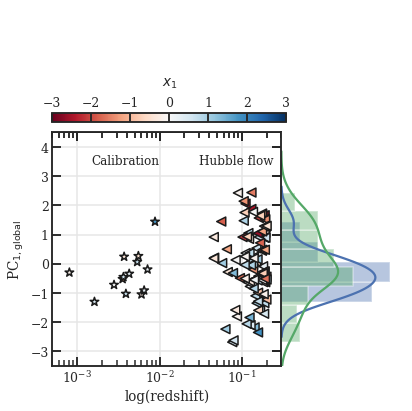

In [68]:
## Global

# combine data into a list
redshift = redshift_cal['redshift'].tolist()+data_global['redshift'].tolist()   # was two DataFrames
pc1 = np.append(pc1_cal_global, pc1_hubble_global).tolist()     # was two numpy arrays
df = pd.DataFrame({'redshift': redshift, 'pc1': pc1})
# documentation says [0,100] but it looks like it should be [0,1]
# cmap = sns.diverging_palette(240, 20, s=99, l=45, sep=20, n=15, center='light', as_cmap=True)
# was 220, 20



# Set up JointGrid
g = sns.JointGrid(x='redshift', y='pc1', data=df, space=0, ratio=2)

# Add data to joint plot
normalize = matplotlib.colors.Normalize(vmin=-3.0, vmax=3.0)
s = g.ax_joint.scatter(redshift_cal['redshift'], pc1_cal_global, marker='*',
                       c=calibration['x_1'], norm=normalize, vmin=-3.0, vmax=3.0,
                       cmap='RdBu', edgecolor='k',
                       label='calibration')
s = g.ax_joint.scatter(data_global['redshift'], pc1_hubble_global, marker='<', 
                       c=data['x1'], norm=normalize, vmin=-3.0, vmax=3.0,
                       cmap="RdBu", edgecolor='k',
                       label='Hubble flow')
# cbaxes = plt.gcf().add_axes([0.1, 0.1, 0.03, 0.8])
# cb = plt.colorbar(s, label=r"$x_1$", cax=cbaxes)
# cb.ax.yaxis.set_ticks_position('left')
cbaxes = plt.gcf().add_axes([0.15, 0.7, 0.542, 0.02])
cb = plt.colorbar(s, label=r"$x_1$", cax=cbaxes, orientation='horizontal')
cbaxes.set_axisbelow(False)    # need this to get the in tick marks to show up
cbaxes.xaxis.set_ticks_position('top')
cbaxes.xaxis.set_label_position('top')
cbaxes.tick_params(axis='both', direction='in', pad=4)   # it appears to just remove the ticks, but I am ok with that.
cbaxes.xaxis.labelpad = 10    # moves the x_1 label



# Fix joint plot stettings
g.ax_joint.set_xscale('log')
g.ax_joint.set_ylim(-3.5,4.5)
g.ax_joint.set_xlim(0.0005, 0.3)
g.ax_joint.tick_params(axis='both', which='both', top='on', right='on', direction='in')
g.ax_joint.grid(which='major', axis='both', color='0.90', linestyle='-')
sns.despine(ax=g.ax_joint, top=False)    # Use despine to add a top 


plt.figtext(0.24, 0.6, "Calibration", fontsize=12)
plt.figtext(0.49, 0.6, "Hubble flow", fontsize=12)

# Add data to y-axis
sns.distplot(pc1_cal_global, label='calibration', ax=g.ax_marg_y, vertical=True, color='b')# color='tab:orange')
sns.distplot(pc1_hubble_global, label='Hubble flow', ax=g.ax_marg_y, vertical=True, color='g')
g.ax_marg_y.set_ylim(-3.5,4.5)

# Add legend to y-axis margin area with joint shapes and margin colors
# plt.legend()

# Fix data to top x-axis


# General Improments
g = g.set_axis_labels('log(redshift)', r'PC$_{1, {\rm global}}$')

plt.savefig('H0_pc1_redshift_global.pdf', bbox_inches='tight')
plt.show()

There appears to be no trend in PC$_1$ with redhsift, other than the known bias in the calibration sample (mostly negative values). The two data sets don't appear to have much of a differance in PC$_1$ distribution, but this looks very sample dependant.

Why is the PC$_1 \approx 2$ in the calibration sample have a $x_1$ value of $\sim 2$? That means it is very very old and very very odd. Large PC$_1$ values are expected to have negative stretch values.

# Extra stuff

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


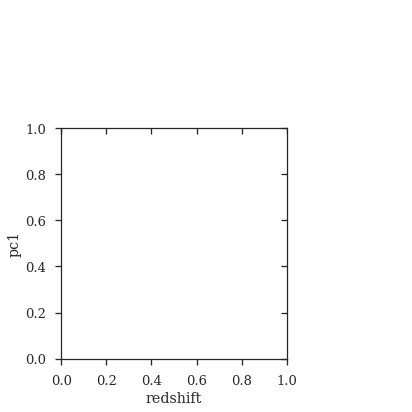

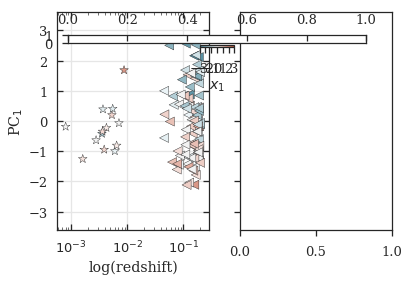

In [44]:
# fig = plt.figure('PC1-v-redshift2')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.subplots_adjust(hspace=0)
# ax = fig.gca()
ax1.set_xscale('log')

normalize = matplotlib.colors.Normalize(vmin=-3.0, vmax=3.0)
cmap = sns.diverging_palette(220, 20, sep=20, n=15, center='light', as_cmap=True)

s = ax1.scatter(redshift_cal['redshift'], pc1_cal_global, marker='*', edgecolor='k',
            c=calibration['x_1'], norm=normalize, vmin=-3.0, vmax=3.0, cmap=cmap,
            label='calibration')
ax1.scatter(data['redshift'], pc1_hubble, marker='<', edgecolor='k',
            c=data['x1'], norm=normalize, vmin=-3.0, vmax=3.0, cmap=cmap,
            label='Hubble flow')

# f.colorbar(s, ax=ax1, label=r"$x_1$", orientation='horizontal', pad=0.25, aspect=40)
# aspect makes it twice as thing

#set axes ticks and gridlines
ax1.tick_params(axis='both', which='both', top='on', right='on', direction='in')
# ax.tick_params(axis='x', )
ax1.grid(which='major', axis='both', color='0.90', linestyle='-')
ax1.set_axisbelow(True)
    
ax1.set_ylim(-3.6,3.6)
ax1.set_xlabel('log(redshift)')
ax1.set_ylabel(r'PC$_1$')
plt.legend()

#Add colorbar
##["{:>4.1f}".format(y) for y in yticks] as possible color bar formating.
# cax = fig.add_axes([0.95, 0.217, 0.02, 0.691])   # fig.set_tight_layout({'pad': 1.5})
# cax = fig.add_axes([0.15, 0.96, 0.691, 0.04])
# cax.tick_params(axis='x', direction='in', top='off', bottom='on', right='on', pad=-24)
# cax.set_axisbelow(False)   # bring tick marks above coloring
# cax.xaxis.set_label_position('bottom')
# cax.xaxis.set_label_coords(0.4955, 1.1)
# plt.colorbar(label=r"$x_1$", cax=cax, orientation='horizontal')

cax = f.add_axes([0.15, 0.76, 0.691, 0.04])
cax.xaxis.set_ticks_position('top')
cax.tick_params(axis='x', top='on', bottom='off', direction='in')
cax.set_axisbelow(False)
# cax = f.add_axes([0.15, 0.16, 0.691, 0.04])
# plt.colorbar(s, ax=cax, label=r"$x_1$", orientation='horizontal', pad=0.0, aspect=40)  # pad put tick marks on the top of joint figure
plt.colorbar(s, ax=cax, label=r"$x_1$", orientation='horizontal')



# plt.savefig('PC1-v-redshift.pdf', bbox_inches='tight')
plt.show()

TODO: historgram is shifted by half a bin?-yes, they have a range of -3 to 3 not -3 to 4. Enlarge 'calibration' and 'Hubble flow'.

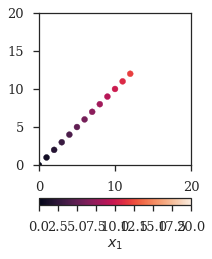

In [137]:
fig = plt.figure('test')

xyc = range(20)

plt.subplot(121)
plt.scatter(xyc[:13], xyc[:13], c=xyc[:13], s=35, vmin=0, vmax=20)

# cax = fig.add_axes([0.15, 0.96, 0.691, 0.04])
# plt.colorbar()
plt.colorbar(label=r"$x_1$", orientation='horizontal', ticklocation='top')
plt.xlim(0, 20)
plt.ylim(0, 20)

plt.show()


<IPython.core.display.Javascript object>


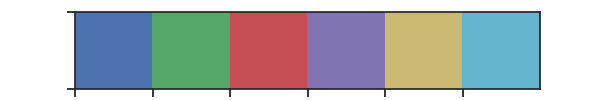

In [387]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [396]:
sns.set_palette(current_palette)

In [393]:
sns.set_palette(sns.color_palette("RdBu_r", 7))